## 1. Download the dataset and import the relevant packages

In [7]:
# Setup kaggle to download the dataset
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [8]:
# Download the dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 661M/675M [00:09<00:00, 88.4MB/s]
100% 675M/675M [00:09<00:00, 71.7MB/s]


In [9]:
import os
!pip install -U -q torch_snippets
from torch_snippets import *

## 2. Specify the indices corresponding to the output classes

In [10]:
id2int = {'Parasitized':0, 'Uninfected': 1}

## 3. Perform the transformations to be done on top of the images

In [11]:
from torchvision import transforms as T

trn_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(128),
  T.CenterCrop(128),
  T.ColorJitter(brightness=(0.95, 1.05),
                contrast=(0.95, 1.05),
                saturation=(0.95, 1.05),
                hue=0.05),

  T.RandomAffine(5, translate=(0.01, 0.1)),
  T.ToTensor(),
  T.Normalize(mean=[0.5, 0.5, 0.5],
              std=[0.5, 0.5, 0.5])
])

# Transformations to be done on the validation images

val_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(128),
  T.CenterCrop(128),
  T.ToTensor(),
  T.Normalize(mean=[0.5, 0.5, 0.5],
              std=[0.5, 0.5, 0.5])
])

## 4. Define the dataset class -MalariaImages

In [12]:
import torch
from torch.utils.data import Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"


class MalariaImages(Dataset):
  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, ix):
    fpath = self.files[ix]
    clss = fname(parent(fpath))
    img = read(fpath, 1)
    return img, clss

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
    _imgs, classes = list(zip(*batch))
    if self.transform:
      imgs = [self.transform(img)[None] for img in _imgs]
    classes = [torch.tensor([id2int[clss]]) for clss in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    return imgs, classes, _imgs

In [13]:
all_files = Glob('cell_images/*/*.png')
len(all_files)

27558

## 5. Fetch the training and validation datasets and dataloaders

In [14]:
from torch.utils.data import DataLoader

all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

# Initialize the datasets
trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)

# Initialize the dataloaders
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)



[10/07/24 19:02:22] INFO     20668                                                                                               ]8;id=430506;file://<ipython-input-12-2eeae185385a>:10\<ipython-input-12-2eeae185385a>]8;;\:]8;id=635629;file://<ipython-input-12-2eeae185385a>:10#__init__:10\__init__:10]8;;\

                    INFO     6890                                                                                                ]8;id=683166;file://<ipython-input-12-2eeae185385a>:10\<ipython-input-12-2eeae185385a>]8;;\:]8;id=895237;file://<ipython-input-12-2eeae185385a>:10#__init__:10\__init__:10]8;;\

## 6.Define the model - MalariaClassifier

In [15]:
import torch.nn as nn

def convBlock(ni, no):
  return nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(ni, no, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
  )


class MalariaClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      convBlock(3, 64),
      convBlock(64, 64),
      convBlock(64, 128),
      convBlock(128, 256),
      convBlock(256, 512),
      convBlock(512, 64),
      nn.Flatten(),
      nn.Linear(256, 256),
      nn.Dropout(0.2),
      nn.ReLU(inplace=True),
      nn.Linear(256, len(id2int))
    )

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    loss = self.loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

## 7. Define functions to train and validate on a batch of data

In [16]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels,_ = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_preds, labels)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels, _ = data
  _preds = model(ims)
  loss, acc = criterion(_preds, labels)
  return loss.item(), acc.item()

## 8. Train the model over increasing epochs



In [17]:
from torch_snippets.torch_loader import Report

model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)

EPOCH: 1.000  trn_acc: 0.886  trn_loss: 0.275  val_loss: 0.193  val_acc: 0.939  (145.21s - 145.21s remaining)
EPOCH: 2.000  trn_acc: 0.945  trn_loss: 0.173  val_loss: 0.158  val_acc: 0.950  (279.31s - 0.00s remaining)


##9. Fetch the convolution layer in the fifth `convBlock` inthe model.

In the preceding line of code, we are fetching the fourth layer of the model and also the first two layers within `convBlock` which happens to be the `conv2D` layer.

In [18]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

##10. Define the `im2gradCAM` function that takes an input image and fetches the heatmap corresponding to activations of the image.

In [19]:
def im2gradCAM(x):
  model.eval()
  logits = model(x)
  heatmaps = []
  activations = im2fmap(x)
  print(activations.shape)
  pred = logits.max(-1)[-1]

  # Get the model's prediction
  model.zero_grad()

  # Compute gradients with respect to model's most confident logit
  logits[0, pred].backward(retain_graph=True)

  # Get the gradients at the required featuremap location
  # and take the avg gradient for every featuremap
  pooled_grads = model.model[-6][1].weight.grad.data.mean((1, 2, 3))

  # Multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_grads[i]

  #take the mean of all weighted activation maps
  #(that has been weighted by avg. grad at each fmap)

  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, "Uninfected" if pred.item() else "Parasitized"

##11. Define the `upsampleHeatmap` function to up-sample the heatmap to a shape that corresponds to the shape of the image

In [24]:
import cv2

SZ = 128
def upsampleHeatmap(map, img):
  m,M = map.min(), map.max()
  map = 255 * ((map -m)/ (M-m))
  map = np.uint8(map)
  map = cv2.resize(map, (SZ, SZ))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  map = np.uint8(map*0.7 + img*0.3)
  return map


##12. In the preceding lines of code, we are de-normalizing the image and also overlaying the heatmap on top of the image.

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


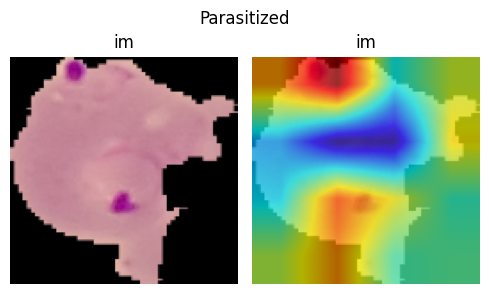

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


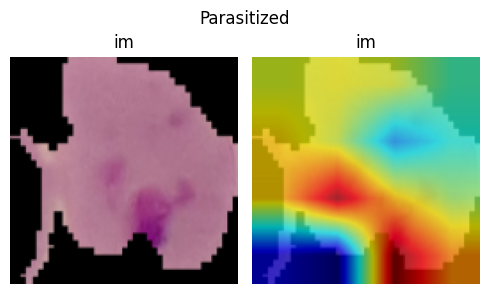

torch.Size([1, 64, 4, 4])


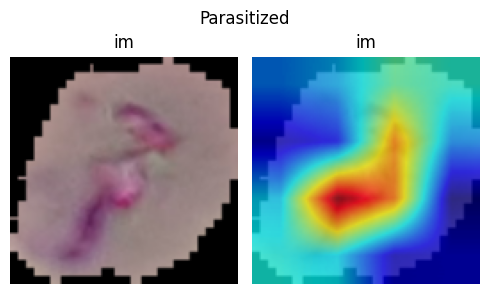

torch.Size([1, 64, 4, 4])


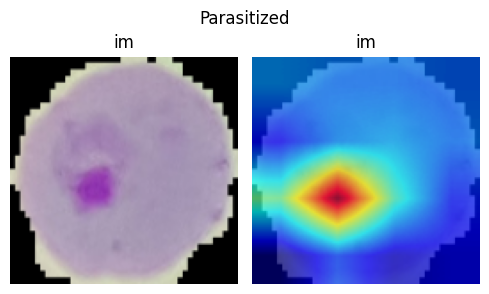

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


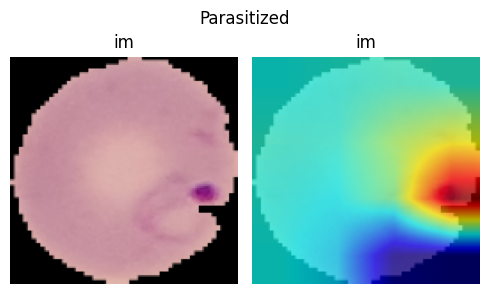

torch.Size([1, 64, 4, 4])


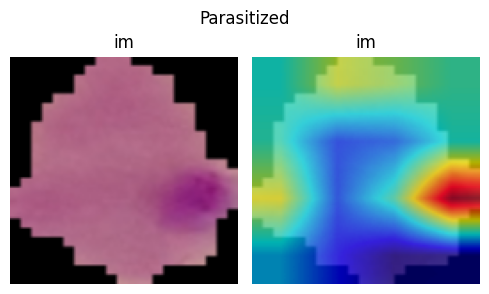

torch.Size([1, 64, 4, 4])


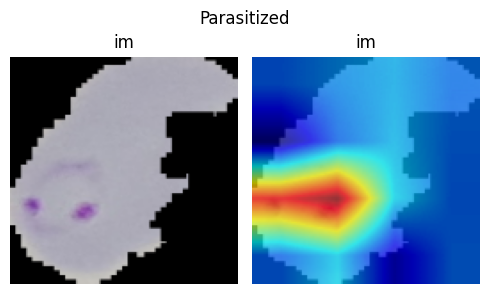

torch.Size([1, 64, 4, 4])


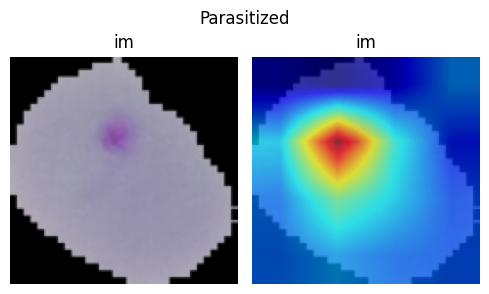

torch.Size([1, 64, 4, 4])


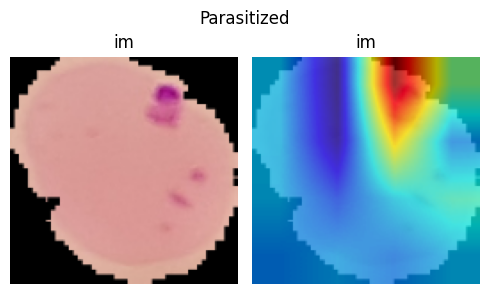

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


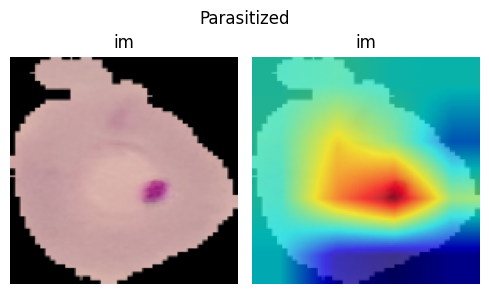

torch.Size([1, 64, 4, 4])


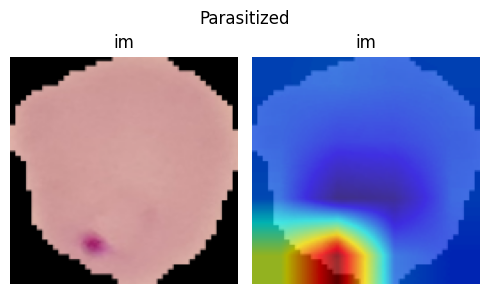

torch.Size([1, 64, 4, 4])


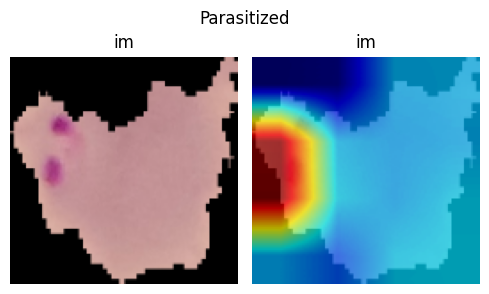

torch.Size([1, 64, 4, 4])


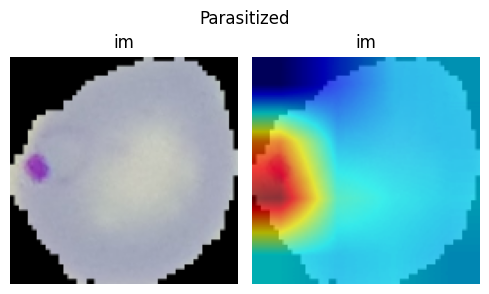

In [25]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x, y, z = next(iter(_val_dl))

for i in range(N):
  image = resize(z[i], SZ)
  heatmap, pred = im2gradCAM(x[i:i+1])
  if (pred == "Uninfected"):
    continue
  heatmap = upsampleHeatmap(heatmap, image)
  subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)